# TASK 1

In [7]:
# setup, imports
# BISMILLAH-IR-REHMAN-IR-RAHEEM

import os
import math    # small math helpers (ceil waghra)
import random           # reproducible shuffling
import time
import copy          # deepcopy models for best chjkpnts
from dataclasses import dataclass
import numpy as np      # is ke ialwa ghar nahi chale ga
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim     # optimizers
from torch.utils.data import DataLoader     # batched loading
from torchvision import datasets, transforms, models  #datasets + aug
from torchvision.transforms import functional as TF   # low level transforms

#seed.random(42)
SEED = 42
random.seed(42)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True   # deterministic convs(slower)
torch.backends.cudnn.benchmark = False      # disable autotuner for determinnsm

import timm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("your device is:",device)

print ("WE ARE READY TO GO!!")

class CFG:
    data_root: str = "./data"  # where STL10 will download
    batch_size: int = 128   # tune dow
    num_workers: int = 2
    epochs: int = 8    # short, were finetuning
    lr: float = 3e-4       # AdamW default works well
    weight_decay: float = 1e-4
    img_size: int = 96       # STL10 default size is 96x96
    num_classes: int = 10   # STL10 = 10 classes
    amp: bool = True         # mixed precision to save compute
    vit_model: str = "vit_small_patch16_224"  # viTS/16 (timm name)
    vit_in_size: int = 224      # ViT expects 224x224
    resnet_in_size: int = 224    # well standardize both at 224
    freeze_backbone_epochs: int = 2   # warmup with head-only training

CFG = CFG()



your device is: cuda
WE ARE READY TO GO!!


In [8]:
# data sets and transforms  -- stylized image 10
# base train/testmm grascale test, translation test, patch shuffle test, patch occlusion test


class TranslateXY:
    """shift theimage by (dx, dy) pixels with reflect padding to keep size"""
    def __init__(self, dx: int, dy: int):
        self.dx = dx
        self.dy = dy
    def __call__(self, img):
        #affine  funct with translation in pixels; fil=0 then pad reflect to avoid black border
        return TF.affine(img, angle=0.0, translate=[self.dx, self.dy], scale=1.0, shear=[ 0.0 , 0.0])


class PatchShuffle:
    """split image into P criss P grid and randomly permute patches"""
    def __init__(self, grid=4):

        self.grid = grid

    def __call__(self, img):

        w, h = img.size
        pw, ph = w // self.grid, h // self.grid
        patches = []

        # cut into patches
        for gy in range(self.grid):

            for gx in range(self.grid):

                patch = img.crop((gx*pw, gy*ph, (gx+1)*pw, (gy+1)*ph))
                patches.append(patch)

        # shuffle order
        random.shuffle(patches)
        # paste back in reading order
        new_img = TF.to_pil_image(torch.zeros( 3, h, w, dtype=torch.uint8))
        k = 0
        for row in range(self.grid):
            for col in range(self.grid):
                new_img.paste(patches[k], (col*pw, row*ph))
                k += 1
        return new_img


# same work, now occlude
class RandomSquareOcclusion:
    """mask a random square patchn (size as fraction of image side) with mean colour"""

    def __init__(self, frac=0.25):
        self.frac = frac

    def __call__(self, img):
        w, h = img.size
        side = int(min(w, h) * self.frac)
        if side < 1:
            return img

        # random top-left
        x0 = random.randint(0, w - side)
        y0 = random.randint(0, h - side)
        # draw a rectangle with the image mean color
        arr = np.array(img)
        mean_color = arr.mean(axis=(0,1)).astype(np.uint8)
        arr[y0:y0+side, x0:x0+side, :] = mean_color
        return TF.to_pil_image(arr)


IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)
# above is normaliazation for imagenet pretrainedbackbone networks


# now train test transforms --resice to 224, nromalize like imagenet
train_tf = transforms.Compose([

    transforms.Resize((CFG.vit_in_size, CFG.vit_in_size)),  # upscale STL10 to 224
    transforms.RandomHorizontalFlip(p=0.5),     # simple aug
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),       # mild color jitter  -- JUST TO SEE IMPACT
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_tf = transforms.Compose([
    transforms.Resize(( CFG.vit_in_size, CFG.vit_in_size)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


# grey scale test -> colour removal, 3 channels
gray_test_tf = transforms.Compose([
    transforms.Resize((CFG.vit_in_size , CFG.vit_in_size)),
    transforms.Grayscale( num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN , IMAGENET_STD),
])

# gray_train_tf = ( [     transforms.Resize((CFG.vit_in_size , CFG.vit_in_size)),
    # transforms.Grayscale( num_output_channels=3),
    # transforms.ToTensor(),
    # transforms.Normalize(IMAGENET_MEAN , IMAGENET_STD),])


# translation test
shift_px =8 # which is approx 3.5 percent of 225
shift_test_tf = transforms.Compose([
    transforms.Resize((CFG.vit_in_size , CFG.vit_in_size)),
    TranslateXY(dx=shift_px , dy=shift_px),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# patch shuffle test->destroy the global layout butkeep local stexture as said in manual
shuffle_test_tf = transforms.Compose([
    transforms.Resize(( CFG.vit_in_size, CFG.vit_in_size)),
    #transforms.shuffle ()
    PatchShuffle(grid=4),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


#occlusion test -> litrly drop a square portion
occl_test_tf = transforms.Compose([
    transforms.Resize((CFG.vit_in_size , CFG.vit_in_size)),
    RandomSquareOcclusion(frac=0.25),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


train_ds = datasets.STL10( root= CFG.data_root, split= 'train' , download=True, transform=train_tf)
test_ds  = datasets.STL10( root= CFG.data_root, split= 'test',  download=True, transform=test_tf)

# same work, but for different tests:
gray_test_ds   = datasets.STL10(root=CFG.data_root, split='test', download=False, transform=gray_test_tf)
shift_test_ds  =datasets.STL10(root=CFG.data_root, split='test', download=False, transform=shift_test_tf)
shuffle_test_ds=datasets.STL10(root=CFG.data_root, split='test', download=False, transform=shuffle_test_tf)
occl_test_ds   = datasets.STL10(root=CFG.data_root, split='test', download=False, transform=occl_test_tf)

# loaders
train_loader= DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, pin_memory=True)
test_loader= DataLoader(test_ds,  batch_size= CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
gray_loader = DataLoader(gray_test_ds,  batch_size=CFG.batch_size, shuffle=False,num_workers=CFG.num_workers, pin_memory=True)
shift_loader= DataLoader(shift_test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
shuffle_loader = DataLoader(shuffle_test_ds, batch_size=CFG.batch_size, shuffle=False,
                            num_workers=CFG.num_workers, pin_memory=True)
occl_loader    = DataLoader(occl_test_ds,    batch_size=CFG.batch_size, shuffle=False,
                            num_workers=CFG.num_workers, pin_memory=True)

print("training dataset size: ", len(train_ds))
print("testing dataset size: ",len(test_ds))
#len(train_ds), len(test_ds)



training dataset size:  5000
testing dataset size:  8000


In [9]:
#models - resnet 50 and vit-s/16
# load imagenet weights, replace heads for 10 classes, and a small helper to count parametrs


def build_resnet50():
    # torchvision resnet50 with ImageNet weights
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    in_features = m.fc.in_features  # final feature dim
    m.fc = nn.Linear(in_features, CFG.num_classes)  # replace classifier
    return m

def build_vit_s16():
    # viT-s/16 pretrained on ImageNet-1k
    m = timm.create_model( CFG.vit_model, pretrained= True, num_classes =CFG.num_classes)
    return m

def count_params(m):
    return sum( p.numel() for p in m.parameters())/1e6

resnet = build_resnet50().to(device) # make model ?
vit    = build_vit_s16().to(device)

print(f"Resnet-50 parameters: {count_params(resnet):.1f}M")
print(f"ViT-s/16 parameters: { count_params(vit):.1f}M")

Resnet-50 parameters: 23.5M
ViT-s/16 parameters: 21.7M


In [10]:
# training utiltiies - one /two epochs because of computer power, or until we reacg good accuracy.
# mixed precision to save compute
# backbone freeeze (optiona, first few epoch)
# accuracy and progress log book


def set_backbone_requires_grad(model , requires_grad: bool , head_names = ("fc", "head")):  # full conv
    """freeze ya  tou unfreeze everything except classifier head/heads"""
    for n, p in model.named_parameters():
        #heuristics: allow final 'fc' (resnet) or head (ViT) to train
        if any (n.startswith(h) for h in head_names):
            p.requires_grad = True
        else:
            p.requires_grad = requires_grad

@torch.no_grad()
def evaluate(model, loader):
    """evaluate accuracy on validation or thetest set"""
    model.eval()
    total = 0
    correct = 0
    for imgs , labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        logits = model(imgs)
        preds = logits.argmax(dim=1)
        total = total + labels.size(0)
        correct = correct + ( preds == labels).sum().item()
    return correct / total


def train_one_epoch(model,loader, optimizer,scaler, epoch, total_epochs):

    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start = time.time()
    for i, (imgs, labels) in enumerate(loader):
        imgs , labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        #amp forward or backward for speed on colab ka gpu
        with torch.cuda.amp.autocast(enabled=CFG.amp):
            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)

        #keep track of acc
        preds = logits.argmax(dim=1)
        total = total + labels.size(0)
        correct= correct+ (preds == labels).sum(). item( )
        running_loss = running_loss+ loss.item() * labels.size(0)

        #amp backw
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        #light progress each approx 2000 images
        if ( i+1) % max(1 , (2000 // CFG.batch_size)) == 0:
            bsz_done = (i+1)*CFG.batch_size  # batch size done
            acc_now = correct / total
            print(f"[epoch {epoch+1}/{total_epochs}] seen={bsz_done:5d} loss={loss.item():.3f} acc~{acc_now:.3f}")

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    dt = time.time() - start
    return epoch_loss, epoch_acc, dt

  # so helps freeze or unfreeze the backbones, eval acc, train one epoch (logging is kept light due to gppu constraints )


In [11]:
# train loops + checkpts for both models
#head only -> faster convergence
#unfreeze all and fine tune

def fit_classifier(model, name: str, train_loader, test_loader, head_names = ("fc","head")):
    # warmup-- train only the last layers

    set_backbone_requires_grad(model, requires_grad=False, head_names=head_names)
    optimizer = optim.AdamW(filter (lambda p: p.requires_grad, model.parameters()), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.amp)

    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())

    for epoch in range(CFG.epochs):
        # unfreeze after warmup
        if epoch == CFG.freeze_backbone_epochs:
            set_backbone_requires_grad(model, requires_grad=True, head_names=head_names)
            optimizer = optim.AdamW(model.parameters() , lr=CFG.lr, weight_decay=CFG.weight_decay)
        #optimizer = optim.SGD()
        loss, train_acc, dt = train_one_epoch(model, train_loader, optimizer, scaler, epoch, CFG.epochs)
        test_acc = evaluate(model, test_loader)
        print(f"[{name}] epoch {epoch+1}/{CFG.epochs} | train_loss={loss:.3f} train_acc={train_acc:.3f} test_acc={test_acc:.3f} ({dt:.1f}s)")

        if test_acc > best_acc:
            best_acc = test_acc
            best_wts = copy.deepcopy(model.state_dict())

    # restore best
    model.load_state_dict(best_wts)
    print(f"[{name}] best test acc: {best_acc:.3f}")
    return model, best_acc


# train resnet 50:
resnet, resnet_best = fit_classifier(resnet, "ResNet50", train_loader, test_loader, head_names=("fc",))

# train vit-s/16
vit, vit_best = fit_classifier(vit, "ViT-S/16", train_loader, test_loader, head_names=("head",))




/tmp/ipython-input-2959286217.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=CFG.amp)
/tmp/ipython-input-1839047573.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.amp):


[epoch 1/8] seen= 1920 loss=1.925 acc~0.421
[epoch 1/8] seen= 3840 loss=1.594 acc~0.595
[ResNet50] epoch 1/8 | train_loss=1.846 train_acc=0.658 test_acc=0.882 (33.1s)
[epoch 2/8] seen= 1920 loss=1.263 acc~0.882
[epoch 2/8] seen= 3840 loss=1.038 acc~0.908
[ResNet50] epoch 2/8 | train_loss=1.188 train_acc=0.912 test_acc=0.933 (33.3s)
[epoch 3/8] seen= 1920 loss=0.100 acc~0.949
[epoch 3/8] seen= 3840 loss=0.167 acc~0.952
[ResNet50] epoch 3/8 | train_loss=0.199 train_acc=0.950 test_acc=0.957 (37.5s)
[epoch 4/8] seen= 1920 loss=0.052 acc~0.983
[epoch 4/8] seen= 3840 loss=0.054 acc~0.982
[ResNet50] epoch 4/8 | train_loss=0.059 train_acc=0.983 test_acc=0.957 (37.9s)
[epoch 5/8] seen= 1920 loss=0.102 acc~0.971
[epoch 5/8] seen= 3840 loss=0.109 acc~0.976
[ResNet50] epoch 5/8 | train_loss=0.069 train_acc=0.979 test_acc=0.958 (36.6s)
[epoch 6/8] seen= 1920 loss=0.029 acc~0.992
[epoch 6/8] seen= 3840 loss=0.016 acc~0.993
[ResNet50] epoch 6/8 | train_loss=0.026 train_acc=0.993 test_acc=0.965 (36.2s

/tmp/ipython-input-3024720872.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=CFG.amp)
/tmp/ipython-input-1839047573.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.amp):


[epoch 1/8] seen= 1920 loss=1.994 acc~0.343
[epoch 1/8] seen= 3840 loss=1.638 acc~0.538
[ResNet50] epoch 1/8 | trn_acc=0.548 val_acc=0.845
[epoch 2/8] seen= 1920 loss=1.330 acc~0.849
[epoch 2/8] seen= 3840 loss=1.125 acc~0.871
[ResNet50] epoch 2/8 | trn_acc=0.873 val_acc=0.905
[epoch 3/8] seen= 1920 loss=0.125 acc~0.948
[epoch 3/8] seen= 3840 loss=0.158 acc~0.952
[ResNet50] epoch 3/8 | trn_acc=0.953 val_acc=0.931
[epoch 4/8] seen= 1920 loss=0.066 acc~0.978
[epoch 4/8] seen= 3840 loss=0.014 acc~0.980
[ResNet50] epoch 4/8 | trn_acc=0.980 val_acc=0.956
[epoch 5/8] seen= 1920 loss=0.018 acc~0.991
[epoch 5/8] seen= 3840 loss=0.017 acc~0.990
[ResNet50] epoch 5/8 | trn_acc=0.990 val_acc=0.956
[epoch 6/8] seen= 1920 loss=0.055 acc~0.992
[epoch 6/8] seen= 3840 loss=0.043 acc~0.990
[ResNet50] epoch 6/8 | trn_acc=0.990 val_acc=0.940
[epoch 7/8] seen= 1920 loss=0.054 acc~0.986
[epoch 7/8] seen= 3840 loss=0.046 acc~0.991
[ResNet50] epoch 7/8 | trn_acc=0.991 val_acc=0.945
[epoch 8/8] seen= 1920 loss

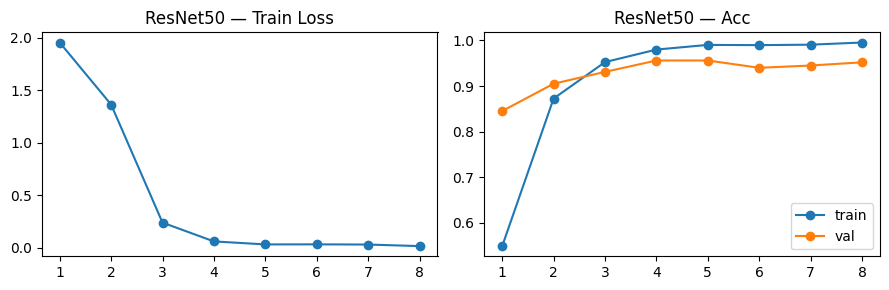

[epoch 1/8] seen= 1920 loss=1.815 acc~0.195
[epoch 1/8] seen= 3840 loss=0.988 acc~0.418
[ViT-S/16] epoch 1/8 | trn_acc=0.435 val_acc=0.821
[epoch 2/8] seen= 1920 loss=0.604 acc~0.880
[epoch 2/8] seen= 3840 loss=0.353 acc~0.904
[ViT-S/16] epoch 2/8 | trn_acc=0.905 val_acc=0.935
[epoch 3/8] seen= 1920 loss=0.165 acc~0.919
[epoch 3/8] seen= 3840 loss=0.089 acc~0.935
[ViT-S/16] epoch 3/8 | trn_acc=0.935 val_acc=0.946
[epoch 4/8] seen= 1920 loss=0.059 acc~0.974
[epoch 4/8] seen= 3840 loss=0.036 acc~0.980
[ViT-S/16] epoch 4/8 | trn_acc=0.980 val_acc=0.952
[epoch 5/8] seen= 1920 loss=0.087 acc~0.984
[epoch 5/8] seen= 3840 loss=0.094 acc~0.984
[ViT-S/16] epoch 5/8 | trn_acc=0.984 val_acc=0.929
[epoch 6/8] seen= 1920 loss=0.055 acc~0.973
[epoch 6/8] seen= 3840 loss=0.155 acc~0.973
[ViT-S/16] epoch 6/8 | trn_acc=0.973 val_acc=0.936
[epoch 7/8] seen= 1920 loss=0.058 acc~0.973
[epoch 7/8] seen= 3840 loss=0.066 acc~0.973
[ViT-S/16] epoch 7/8 | trn_acc=0.973 val_acc=0.946
[epoch 8/8] seen= 1920 loss

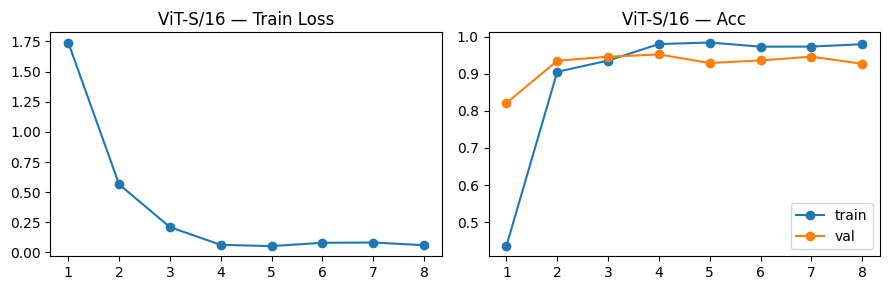

In [12]:
# cell 5 A --- train val split + traininv curves as said in manual - i for got so now have to re run the entire notebook
from torch.utils.data import random_split, Subset
import matplotlib.pyplot as plt

#80/20 split of the original STL10 train (5000 images)
val_frac = 0.2
n_train = len(train_ds)
n_val = int(n_train * val_frac)
n_trn = n_train - n_val
train_ds_trn, train_ds_val = random_split(train_ds, [n_trn ,n_val], generator=torch.Generator().manual_seed(SEED))

train_loader_trn =DataLoader(train_ds_trn, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, pin_memory=True)
train_loader_val = DataLoader(train_ds_val, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

def fit_with_curves(model, name: str, head_names=("fc","head")):

    set_backbone_requires_grad(model, requires_grad=False, head_names=head_names)
    #optimizer = optim.SG()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.amp)

    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())
    hist = {"epoch": [], "trn_acc": [], "val_acc": [], "trn_loss": []}

    for epoch in range(CFG.epochs):
        if epoch == CFG.freeze_backbone_epochs:
            set_backbone_requires_grad(model, requires_grad=True, head_names=head_names)
            optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)

        loss, trn_acc, _ = train_one_epoch(model, train_loader_trn, optimizer, scaler, epoch, CFG.epochs)
        val_acc = evaluate(model, train_loader_val)
        hist["epoch"].append(epoch+1); hist["trn_acc"].append(trn_acc); hist["val_acc"].append(val_acc); hist["trn_loss"].append(loss)
        print(f"[{name}] epoch {epoch+1}/{CFG.epochs} | trn_acc={trn_acc:.3f} val_acc={val_acc:.3f}")

        # best_acc = 0.0
        # best_wts = copy.deepcopy(model.state_dict())
        # hist = {"epoch": [], "trn_acc": [], "val_acc": [], "trn_loss": []}

        if val_acc > best_acc:
            best_acc = val_acc
            best_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_wts)
    # final test accuracy on clean test set:
    test_acc = evaluate(model, test_loader)
    print(f"[{name}] best val acc: {best_acc:.3f} | test acc: {test_acc:.3f}")

    # plot curves
    fig, ax = plt.subplots(1,2, figsize=(9,3))
    ax[0].plot(hist["epoch"], hist["trn_loss"], marker='o'); ax[0].set_title(f"{name} — Train Loss")
    ax[1].plot(hist["epoch"], hist["trn_acc"], marker='o', label="train")
    ax[1].plot(hist["epoch"], hist["val_acc"], marker='o', label="val")
    ax[1].set_title(f"{name} - Acc"); ax[1].legend(); plt.tight_layout(); plt.show()
    return model, hist

# Rebuild fresh models (to avoid state confusion)
resnet_curves = build_resnet50().to(DEVICE)
vit_curves    = build_vit_s16().to(DEVICE)

resnet_curves, resnet_hist = fit_with_curves(resnet_curves, "ResNet50", head_names=("fc",))
vit_curves,vit_hist= fit_with_curves(vit_curves,"ViT-S/16", head_names=("head",))

In [13]:
# baseline and bias probing
# clean test acc (baseline)
#grey scale test (colour bias)
# trans. test -> trans. invariance  acc + consistency
# patch shuffle and occl. -> globality vs locality
import matplotlib.pyplot as plt
import cv2

@torch.no_grad()
def accuracy_and_consistency(model, clean_loader, altered_loader):
    """return (acc_altered , consistency_with_clean)
       Consistency = fraction of samples whose top 1 prediction stays the same"""

    model.eval()
    # pass1- collect clean preds in order
    clean_preds = []
    for imgs, _ in clean_loader:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        clean_preds.append(logits.argmax(1).cpu())
    clean_preds = torch.cat(clean_preds)

    #pass2: altered preds + accuracy on altered set
    correct = 0
    total = 0
    alt_preds = []
    alt_labels = []
    for imgs, labels in altered_loader:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        preds = logits.argmax(1).cpu()
        alt_preds.append(preds)
        alt_labels.append(labels)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    alt_preds = torch.cat(alt_preds)
    alt_labels = torch.cat(alt_labels)

    #consistency assumes loaders are aligned on the same test order
    same = (alt_preds == clean_preds[ :len(alt_preds)]).float().mean().item()  # ERROR THA , CLEAN PREDS FROM START : LEN OFALL
    acc = (correct)/ total
    #total =
    return acc, same

#baselines on clean test
resnet_clean = evaluate(resnet, test_loader)
vit_clean = evaluate(vit,test_loader)
print(f"Clean test acc - ResNet50: {resnet_clean:.3f} | ViT-S/16: {vit_clean:.3f}")


#grayscale: colour bias (drop = reliance on color)
resnet_gray = evaluate(resnet, gray_loader)
vit_gray= evaluate(vit,gray_loader)
print(f"Grayscale acc- ResNet50: {resnet_gray:.3f} | ViT-S/16: {vit_gray:.3f}")
print(f"Δcolor drop - ResNet50: {resnet_clean-resnet_gray:.3f} | ViT-S/16: {vit_clean-vit_gray:.3f}")

#translation invariance: accuracy + consistency (same-pred after shift)
resnet_shift_acc, resnet_shift_cons = accuracy_and_consistency(resnet, test_loader, shift_loader)
vit_shift_acc, vit_shift_cons = accuracy_and_consistency(vit, test_loader, shift_loader)
print(f"Shifted acc - ResNet50: {resnet_shift_acc:.3f} | ViT-S/16: {vit_shift_acc:.3f}")
print(f"Consistency- ResNet50: {resnet_shift_cons:.3f} | ViT-S/16: {vit_shift_cons:.3f}")

#aatch shuffle: disrupt global layout (shape) keep local texture=
resnet_shuffle = evaluate(resnet, shuffle_loader)
vit_shuffle = evaluate(vit,shuffle_loader)
print(f"Patch-shuffle - ResNet50: {resnet_shuffle:.3f} | ViT-S/16: {vit_shuffle:.3f}")

#occlusion- robustness to missing parts
resnet_occl = evaluate(resnet, occl_loader)
vit_occl = evaluate(vit,occl_loader)
print(f"Occlusion -  ResNet50: {resnet_occl:.3f} | ViT-S/16: {vit_occl:.3f}")

# summarise  : compute the clean baselines, grey sacale acc and dropm translation acc and consistency vs clean  (how often pred class stayed inchaged after shifting, ), and occlusion acc to probe global vs local robustness


Clean test acc - ResNet50: 0.965 | ViT-S/16: 0.960
Grayscale acc- ResNet50: 0.930 | ViT-S/16: 0.915
Δcolor drop - ResNet50: 0.035 | ViT-S/16: 0.046
Shifted acc - ResNet50: 0.965 | ViT-S/16: 0.955
Consistency- ResNet50: 0.982 | ViT-S/16: 0.964
Patch-shuffle - ResNet50: 0.880 | ViT-S/16: 0.745
Occlusion -  ResNet50: 0.962 | ViT-S/16: 0.951


ResNet-50 Grad-CAM — Clean


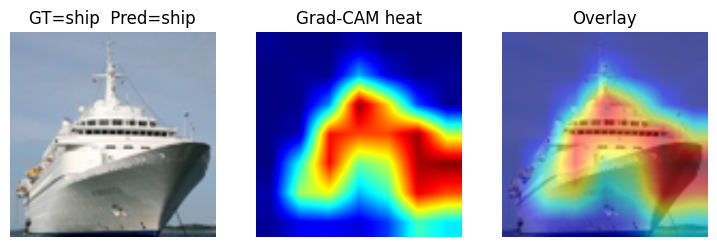

ResNet-50 Grad-CAM — Patch-shuffled


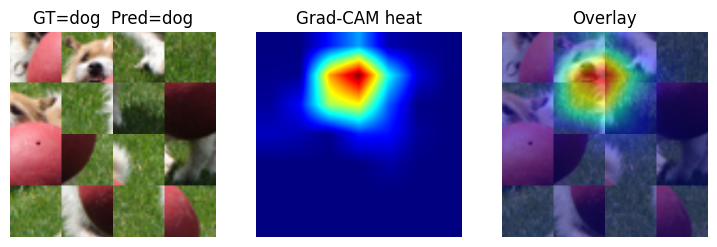

In [16]:
# cell 6A ? RESNET 50 GRADCAM (last conv) - for my own sake to visualize results

class GradCAM_ResNet50:
    # target layer: last conv "layer4[-1].conv3" (post-activation map = 'layer4')
    def __init__(self, model, target_layer_name="layer4"):
        self.model = model.eval()
        self.target_acts = None
        self.target_grads = None

        def fwd_hook(module, inp, out):
            self.target_acts = out.detach()

        def bwd_hook(module, grad_in, grad_out):
            self.target_grads = grad_out[0].detach()

        # hook the whole layer4 (easier than exact Conv)
        self.handle_f = getattr(self.model, target_layer_name).register_forward_hook(fwd_hook)
        self.handle_b = getattr(self.model, target_layer_name).register_full_backward_hook(bwd_hook)

    def __del__(self):
        self.handle_f.remove()
        self.handle_b.remove()

    @torch.no_grad()
    def _denorm(self, x):
        # x: (3,H,W) normalized -> uint8 RGB for overlay
        x = x.cpu().numpy().transpose(1,2,0)
        x = (x * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)).clip(0,1)
        return (x * 255).astype(np.uint8)

    def __call__(self, img_tensor, target_idx=None):
        """
        img_tensor: (1,3,224,224) normalized
        target_idx: class index to visualize; default uses model's top-1
        """
        self.model.zero_grad(set_to_none=True)
        logits = self.model(img_tensor)
        if target_idx is None:
            target_idx = logits.argmax(dim=1).item()

        # backprop d(logit[target]) / d(features)
        score = logits[:, target_idx]
        score.backward(retain_graph=True)

        # Grad-CAM weights: GAP over gradients
        grads = self.target_grads   # (N,C,H,W)
        acts  = self.target_acts     # (N,C,H,W)
        alpha = grads.mean(dim=(2,3), keepdim=True)    # (N,C,1,1)
        cam = (alpha * acts).sum(dim=1, keepdim=True)  # (N,1,H,W)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = cam / (cam.max() + 1e-6)

        # upsample to 224x224 for overlay
        cam_up = cv2.resize(cam, (img_tensor.shape[-1], img_tensor.shape[-2]))
        base = self._denorm(img_tensor[0])
        heat = cv2.applyColorMap(np.uint8(255 * cam_up), cv2.COLORMAP_JET)
        heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
        overlay = (0.5 * base + 0.5 * heat).astype(np.uint8)
        return base, heat, overlay, int(target_idx)

#helper to fetch a sample from any dataset + run Grad-CAM
def gradcam_demo_resnet(sample_ds, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(sample_ds))
    x, y = sample_ds[idx]
    with torch.no_grad():
        inp = x.unsqueeze(0).to(DEVICE)
    cam = GradCAM_ResNet50(resnet)
    base, heat, overlay, t = cam(inp)
    pred = resnet(inp).argmax(1).item()

    # NEW: map numeric labels to class names
    class_names = sample_ds.dataset.classes if hasattr(sample_ds, "dataset") else sample_ds.classes
    gt_name   = class_names[y]
    pred_name = class_names[pred]

    fig, axs = plt.subplots(1,3,figsize=(9,3))
    axs[0].imshow(base);
    axs[0].set_title(f"GT={gt_name}  Pred={pred_name}")
    axs[1].imshow(heat);
    axs[1].set_title("Grad-CAM heat")
    axs[2].imshow(overlay);
    axs[2].set_title("Overlay")
    for ax in axs: ax.axis('off')
    plt.show()

#ry on clean vs patch-shuffle to highlight texture bias differences
print("ResNet-50 Grad-CAM — Clean")
gradcam_demo_resnet(test_ds)
print("ResNet-50 Grad-CAM — Patch-shuffled")
gradcam_demo_resnet(shuffle_test_ds)

blocks.0.attn Attention
blocks.0.attn.qkv Linear
blocks.0.attn.q_norm Identity
blocks.0.attn.k_norm Identity
blocks.0.attn.attn_drop Dropout
blocks.0.attn.norm Identity
blocks.0.attn.proj Linear
blocks.0.attn.proj_drop Dropout
blocks.1.attn Attention
blocks.1.attn.qkv Linear
blocks.1.attn.q_norm Identity
blocks.1.attn.k_norm Identity
blocks.1.attn.attn_drop Dropout
blocks.1.attn.norm Identity
blocks.1.attn.proj Linear
blocks.1.attn.proj_drop Dropout
blocks.2.attn Attention
blocks.2.attn.qkv Linear
blocks.2.attn.q_norm Identity
blocks.2.attn.k_norm Identity
blocks.2.attn.attn_drop Dropout
blocks.2.attn.norm Identity
blocks.2.attn.proj Linear
blocks.2.attn.proj_drop Dropout
blocks.3.attn Attention
blocks.3.attn.qkv Linear
blocks.3.attn.q_norm Identity
blocks.3.attn.k_norm Identity
blocks.3.attn.attn_drop Dropout
blocks.3.attn.norm Identity
blocks.3.attn.proj Linear
blocks.3.attn.proj_drop Dropout
blocks.4.attn Attention
blocks.4.attn.qkv Linear
blocks.4.attn.q_norm Identity
blocks.4.attn

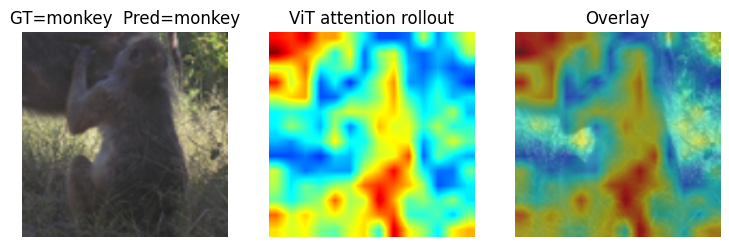

ViT rollout — Shifted (position sensitivity)


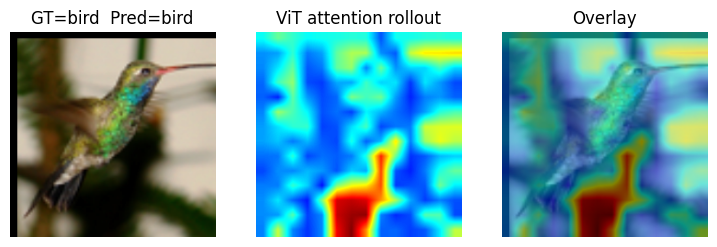

In [22]:
# def vit_attention_rollout(model, x, discard_ratio=0.0):
#     """
#     Attention rollout for HuggingFace ViT.
#     Returns: base image, heatmap, overlay
#     """
#     model.eval()
#     attn_weights = []

#     # hook into all self-attention modules
#     def hook(module, inp, out):
#         # HuggingFace ViT: out = (attn_output, attn_probs)
#         if isinstance(out, tuple) and len(out) > 1:
#             attn_probs = out[1]  # (B, heads, tokens, tokens)
#             attn_weights.append(attn_probs.detach().cpu())

#     handles = []
#     for name, module in model.named_modules():
#         if module.__class__.__name__ == "ViTSelfAttention":
#             handles.append(module.register_forward_hook(hook))

#     with torch.no_grad():
#         _ = model(x)   # run one forward pass

#     for h in handles:
#         h.remove()

#     if len(attn_weights) == 0:
#         raise RuntimeError("No attention maps captured — check model type (must be HuggingFace ViT)")

#     # average over heads
#     attn = [a.mean(dim=1) for a in attn_weights]  # list of (B,T,T)
#     attn_mat = torch.eye(attn[0].shape[-1])
#     for a in attn:
#         a = a[0]   # (T,T)
#         if discard_ratio > 0:
#             flat = a.view(-1)
#             n_drop = int(flat.numel() * discard_ratio)
#             if n_drop > 0:
#                 thr = torch.topk(flat, n_drop, largest=False).values.max()
#                 a = torch.where(a <= thr, torch.zeros_like(a), a)
#         a = a / (a.sum(dim=-1, keepdim=True) + 1e-6)
#         attn_mat = a @ attn_mat

#     # attention from CLS token to patches
#     cls_attn = attn_mat[0, 1:]
#     side = int((cls_attn.numel())**0.5)
#     grid = cls_attn.reshape(side, side).numpy()
#     grid = grid / (grid.max() + 1e-6)

#     # upsample to image size and overlay
#     heat_up = cv2.resize(grid, (x.shape[-1], x.shape[-2]))
#     base = (x[0].cpu().numpy().transpose(1,2,0) * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)).clip(0,1)
#     base = (base * 255).astype(np.uint8)
#     heat_color = cv2.applyColorMap(np.uint8(255*heat_up), cv2.COLORMAP_JET)
#     heat_color = cv2.cvtColor(heat_color, cv2.COLOR_BGR2RGB)
#     overlay = (0.5*base + 0.5*heat_color).astype(np.uint8)
#     return base, heat_color, overlay

# def vit_rollout_demo(sample_ds, idx=None, discard_ratio=0.0):
#     if idx is None: idx = np.random.randint(0, len(sample_ds))
#     x, y = sample_ds[idx]
#     with torch.no_grad():
#         inp = x.unsqueeze(0).to(DEVICE)
#     base, heat, overlay = vit_attention_rollout(vit, inp, discard_ratio=discard_ratio)
#     pred = vit(inp).argmax(1).item()

#     # use class names instead of ints
#     class_names = sample_ds.dataset.classes if hasattr(sample_ds, "dataset") else sample_ds.classes
#     gt_name   = class_names[y]
#     pred_name = class_names[pred]

#     fig, axs = plt.subplots(1,3,figsize=(9,3))
#     axs[0].imshow(base);
#     axs[0].set_title(f"GT={gt_name} Pred={pred_name}")
#     axs[1].imshow(heat);
#     axs[1].set_title("ViT attention rollout")
#     axs[2].imshow(overlay);
#     axs[2].set_title("Overlay")
#     for ax in axs: ax.axis('off')
#     plt.show()

# print("ViT rollout — Clean")
# vit_rollout_demo(test_ds)
# print("ViT rollout — Shifted (position sensitivity)")
# vit_rollout_demo(shift_test_ds)

for name, module in vit.named_modules():
    if "attn" in name.lower() or "attention" in name.lower():
        print(name, module.__class__.__name__)

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Use your dataset-specific normalization (assuming you defined IMAGENET_MEAN, IMAGENET_STD earlier)
# If not, define them here:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def vit_attention_rollout_torchvision(model, x, discard_ratio=0.0):
    """
    Attention rollout for torchvision VisionTransformer (e.g., vit_b_16, vit_s_16).
    Reconstructs attention maps from qkv in each Attention block.
    """
    model.eval()
    attn_weights = []

    def hook(module, inp, out):
        # inp[0] = hidden states (B, N, D)
        B, N, D = inp[0].shape
        qkv = module.qkv(inp[0])  # (B, N, 3*D)
        qkv = qkv.reshape(B, N, 3, module.num_heads, D // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1) ** 0.5))  # (B, heads, N, N)
        attn = attn.softmax(dim=-1)
        attn_weights.append(attn.detach().cpu())

    handles = []
    for name, module in model.named_modules():
        if module.__class__.__name__ == "Attention":
            handles.append(module.register_forward_hook(hook))

    with torch.no_grad():
        _ = model(x)

    for h in handles:
        h.remove()

    if len(attn_weights) == 0:
        raise RuntimeError("No attention maps captured — confirm model is torchvision VisionTransformer")

    # Average over heads and rollout
    attn = [a.mean(dim=1) for a in attn_weights]  # list of (B, N, N)
    attn_mat = torch.eye(attn[0].shape[-1])
    for a in attn:
        a = a[0]   # (N, N)
        if discard_ratio > 0:
            flat = a.view(-1)
            n_drop = int(flat.numel() * discard_ratio)
            if n_drop > 0:
                thr = torch.topk(flat, n_drop, largest=False).values.max()
                a = torch.where(a <= thr, torch.zeros_like(a), a)
        a = a / (a.sum(dim=-1, keepdim=True) + 1e-6)
        attn_mat = a @ attn_mat

    # Attention from CLS token to patches
    cls_attn = attn_mat[0, 1:]
    side = int((cls_attn.numel())**0.5)
    grid = cls_attn.reshape(side, side).numpy()
    grid = grid / (grid.max() + 1e-6)

    # Upsample to image size and overlay
    heat_up = cv2.resize(grid, (x.shape[-1], x.shape[-2]))
    base = (x[0].cpu().numpy().transpose(1,2,0) * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)).clip(0,1)
    base = (base * 255).astype(np.uint8)
    heat_color = cv2.applyColorMap(np.uint8(255*heat_up), cv2.COLORMAP_JET)
    heat_color = cv2.cvtColor(heat_color, cv2.COLOR_BGR2RGB)
    overlay = (0.5*base + 0.5*heat_color).astype(np.uint8)
    return base, heat_color, overlay

# --- Demo helper ---
def vit_rollout_demo(sample_ds, vit_model, idx=None, discard_ratio=0.0, device="cuda"):
    if idx is None:
        idx = np.random.randint(0, len(sample_ds))
    x, y = sample_ds[idx]
    with torch.no_grad():
        inp = x.unsqueeze(0).to(device)

    base, heat, overlay = vit_attention_rollout_torchvision(vit_model, inp, discard_ratio=discard_ratio)
    pred = vit_model(inp).argmax(1).item()

    # human-readable class names
    if hasattr(sample_ds, "dataset") and hasattr(sample_ds.dataset, "classes"):
        class_names = sample_ds.dataset.classes
    elif hasattr(sample_ds, "classes"):
        class_names = sample_ds.classes
    else:
        class_names = [str(i) for i in range(10)]

    gt_name   = class_names[y]
    pred_name = class_names[pred]

    fig, axs = plt.subplots(1,3,figsize=(9,3))
    axs[0].imshow(base);
    axs[0].set_title(f"GT={gt_name}  Pred={pred_name}")
    axs[1].imshow(heat);
    axs[1].set_title("ViT attention rollout")
    axs[2].imshow(overlay);
    axs[2].set_title("Overlay")
    for ax in axs: ax.axis('off')
    plt.show()

# --- Usage Example ---
print("ViT rollout — Clean")
vit_rollout_demo(test_ds, vit, device=DEVICE)
print("ViT rollout — Shifted (position sensitivity)")
vit_rollout_demo(shift_test_ds, vit, device=DEVICE)


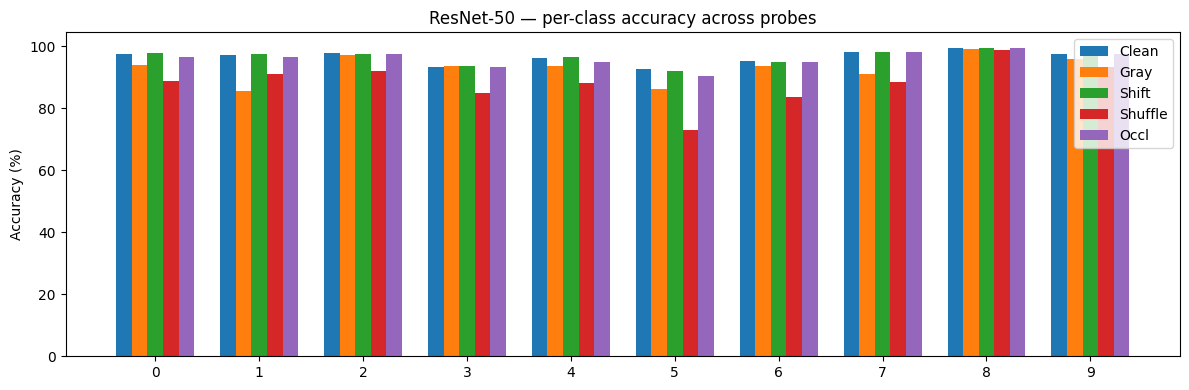

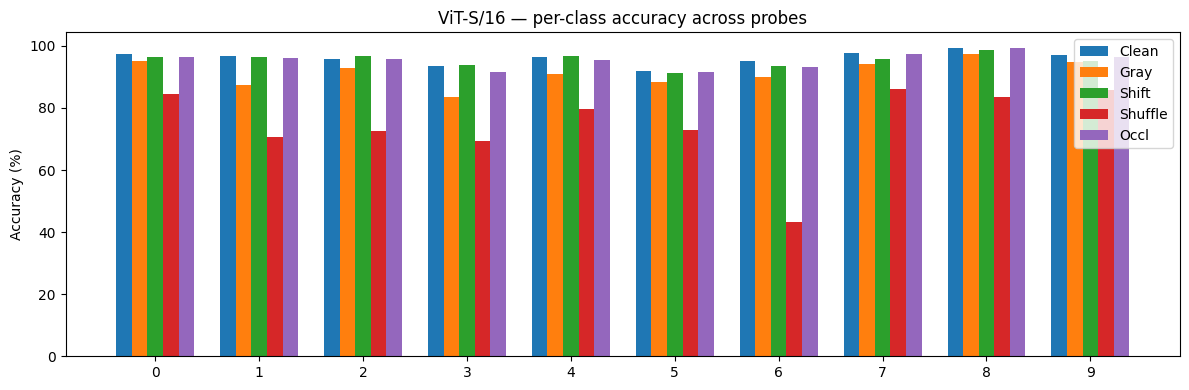

In [23]:
# 6c -> oer class acc bars across probes
from collections import defaultdict

@torch.no_grad()
def per_class_acc(model, loader, n_classes=10):
    model.eval()
    correct = np.zeros(n_classes, dtype=np.int64)
    total   = np.zeros(n_classes, dtype=np.int64)
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.numpy()
        preds = model(imgs).argmax(1).cpu().numpy()
        for y, p in zip(labels, preds):
            total[y] += 1
            correct[y] += int(y == p)
    return (correct / np.maximum(1, total)), correct, total

def plot_per_class(matrix, title, class_names=None):
    # matrix: dict {"Clean":acc_vec, "Gray":acc_vec, ...}
    keys = list(matrix.keys())
    accs = np.stack([matrix[k] for k in keys], axis=1) # (C, K)
    C, K = accs.shape
    x = np.arange(C)
    w = 0.15
    plt.figure(figsize=(12,4))
    for i in range(K):
        plt.bar(x + i*w, accs[:,i]*100, width=w, label=keys[i])
    if class_names is None:
        class_names = [str(i) for i in range(C)]
    plt.xticks(x + w*(K-1)/2, class_names, rotation=0)
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# compute for both models
def per_class_panel(model, name):
    clean,_c,_t = per_class_acc(model, test_loader)
    gray,_1,_2  = per_class_acc(model, gray_loader)
    shift,_3,_4 = per_class_acc(model, shift_loader)
    shuf,_5,_6  = per_class_acc(model, shuffle_loader)
    occl,_7,_8  = per_class_acc(model, occl_loader)
    plot_per_class(
        {"Clean":clean, "Gray":gray, "Shift":shift, "Shuffle":shuf, "Occl":occl},
        f"{name} — per-class accuracy across probes"
    )

per_class_panel(resnet, "ResNet-50")
per_class_panel(vit, "ViT-S/16")

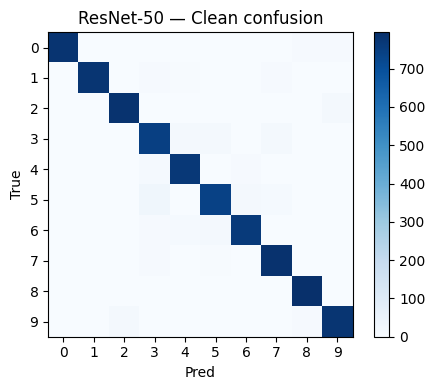

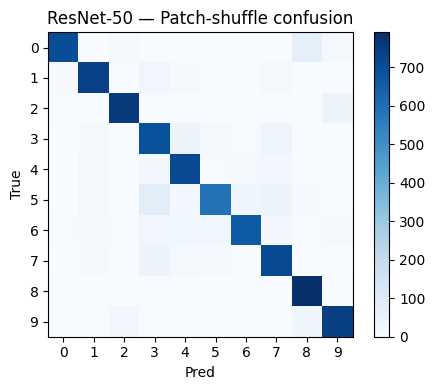

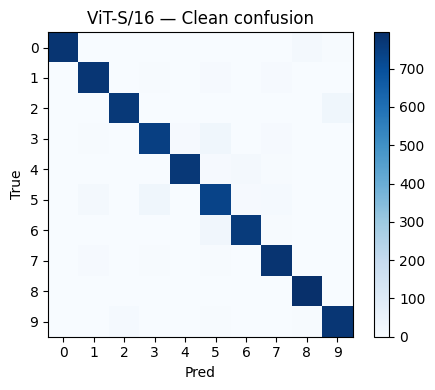

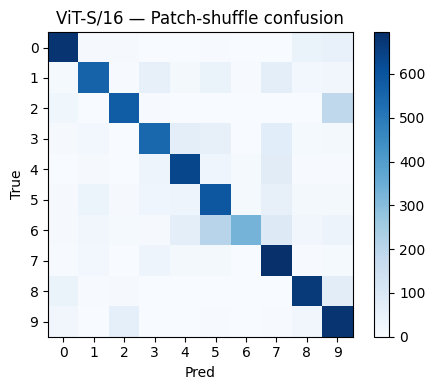

In [24]:
# confusion matrices clean vs huffled
from sklearn.metrics import confusion_matrix

@torch.no_grad()
def preds_and_labels(model, loader):
    model.eval()
    P, Y = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        p = model(x).argmax(1).cpu().numpy()
        P.append(p); Y.append(y.numpy())
    return np.concatenate(P), np.concatenate(Y)

def plot_confmat(cm, title):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title); plt.colorbar()
    ticks = np.arange(CFG.num_classes)
    plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
    plt.xlabel('Pred'); plt.ylabel('True')
    plt.tight_layout(); plt.show()

#resNet
p_clean, y_clean = preds_and_labels(resnet, test_loader)
p_shuf,  y_shuf  = preds_and_labels(resnet, shuffle_loader)
plot_confmat(confusion_matrix(y_clean, p_clean), "ResNet-50 — Clean confusion")
plot_confmat(confusion_matrix(y_shuf,  p_shuf),  "ResNet-50 — Patch-shuffle confusion")

# ViT
p_clean_v, y_clean_v = preds_and_labels(vit, test_loader)
p_shuf_v,  y_shuf_v  = preds_and_labels(vit, shuffle_loader)
plot_confmat(confusion_matrix(y_clean_v, p_clean_v), "ViT-S/16 — Clean confusion")
plot_confmat(confusion_matrix(y_shuf_v,  p_shuf_v),  "ViT-S/16 — Patch-shuffle confusion")

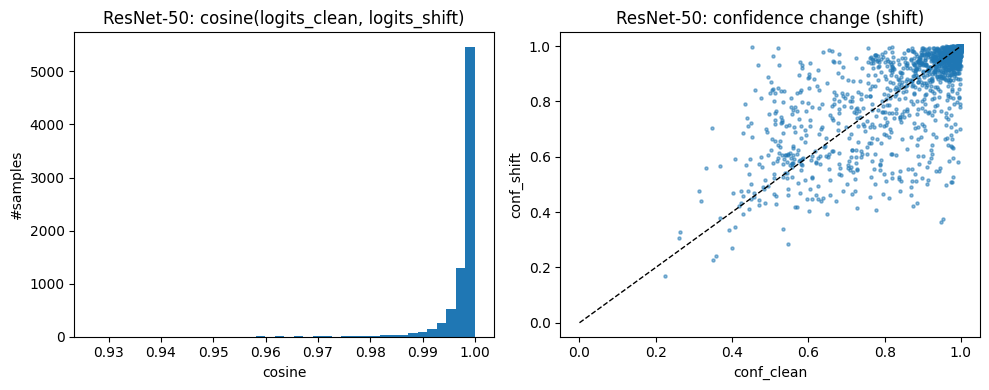

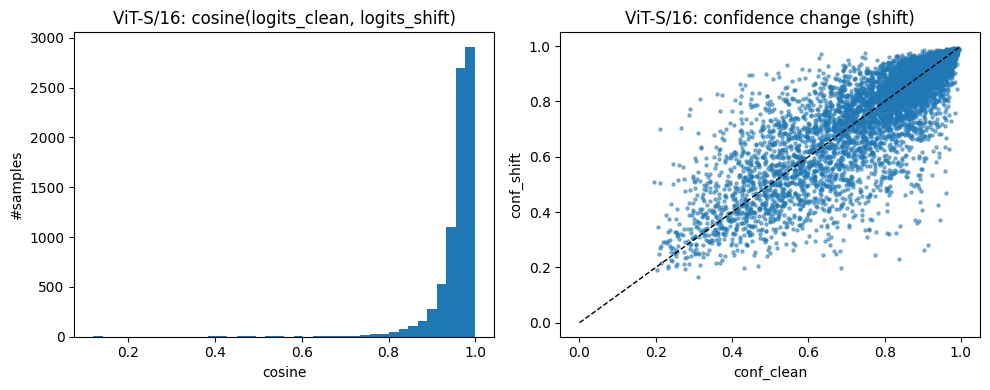

In [25]:
#logit similarity and confidence change (shift)
import matplotlib.pyplot as plt
import torch.nn.functional as F

@torch.no_grad()
def logits_list(model, loader):
    model.eval()
    L = []
    for x, _ in loader:
        x = x.to(DEVICE)
        L.append(model(x).cpu())
    return torch.cat(L, dim=0)  # (N, C)

def plot_logit_consistency(model, name):
    L_clean = logits_list(model, test_loader)
    L_shift = logits_list(model, shift_loader)
    # cosine between clean and shifted logits (per-sample)
    cos = F.cosine_similarity(L_clean, L_shift, dim=1).numpy()
    # confidence (softmax max prob)
    conf_clean = F.softmax(L_clean, dim=1).max(1).values.numpy()
    conf_shift = F.softmax(L_shift, dim=1).max(1).values.numpy()

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(cos, bins=40)
    plt.title(f"{name}: cosine(logits_clean, logits_shift)")
    plt.xlabel("cosine"); plt.ylabel("#samples")

    plt.subplot(1,2,2)
    plt.scatter(conf_clean, conf_shift, s=5, alpha=0.5)
    plt.plot([0,1],[0,1],'k--',lw=1)
    plt.xlabel("conf_clean"); plt.ylabel("conf_shift")
    plt.title(f"{name}: confidence change (shift)")
    plt.tight_layout(); plt.show()

plot_logit_consistency(resnet, "ResNet-50")
plot_logit_consistency(vit,    "ViT-S/16")



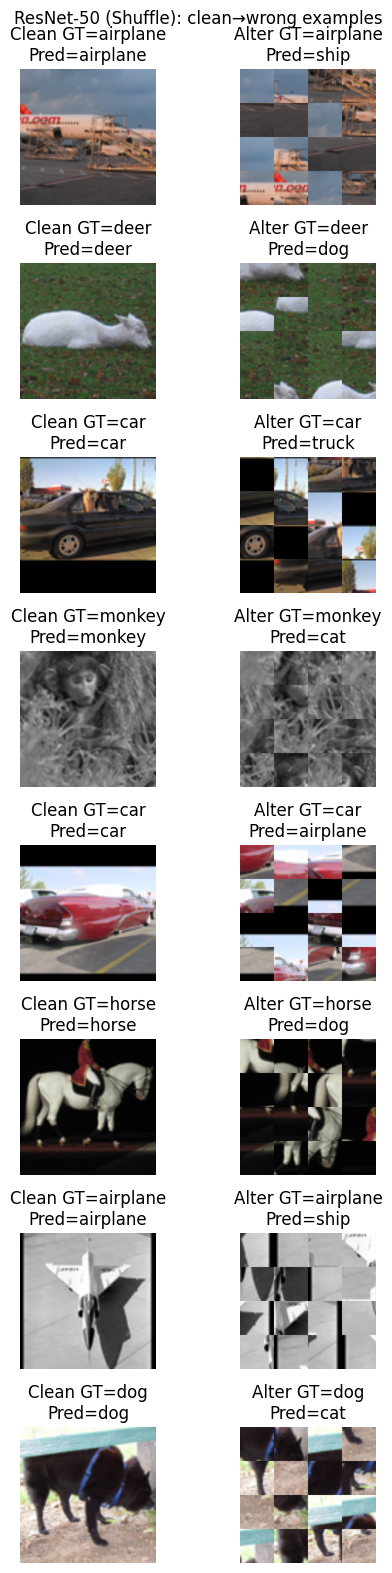

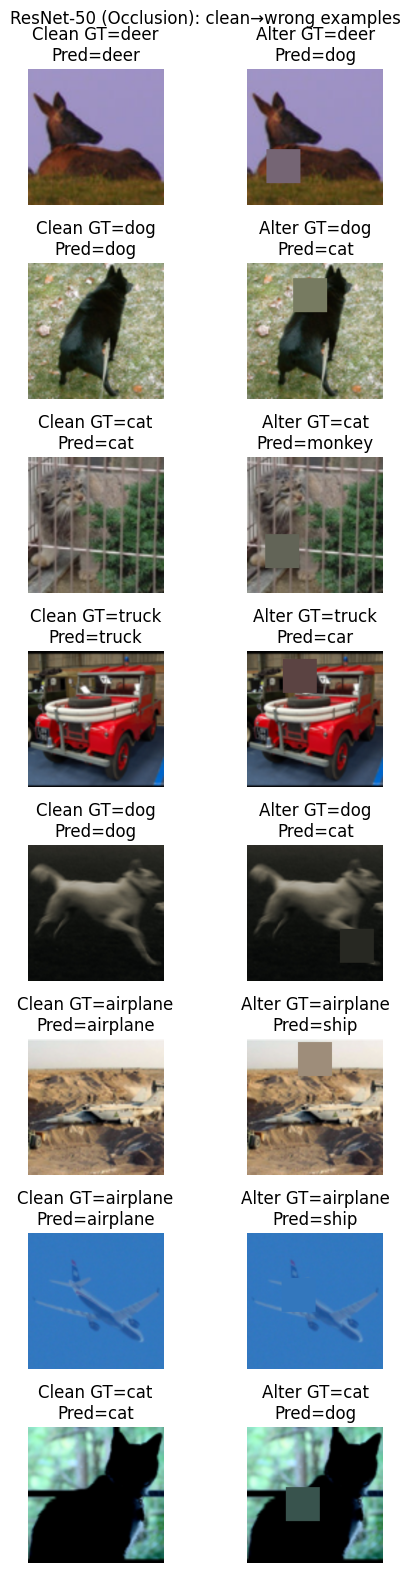

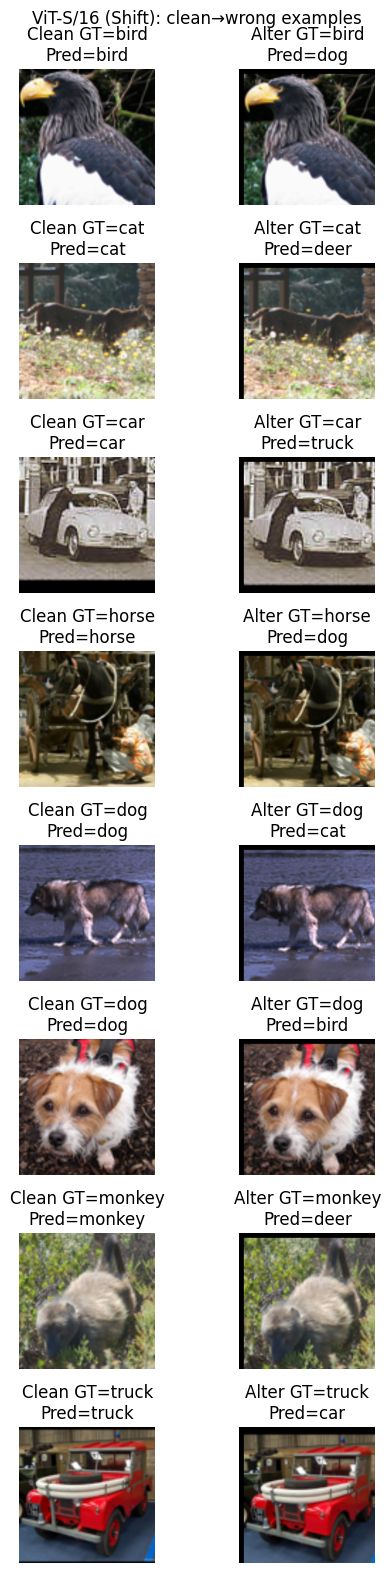

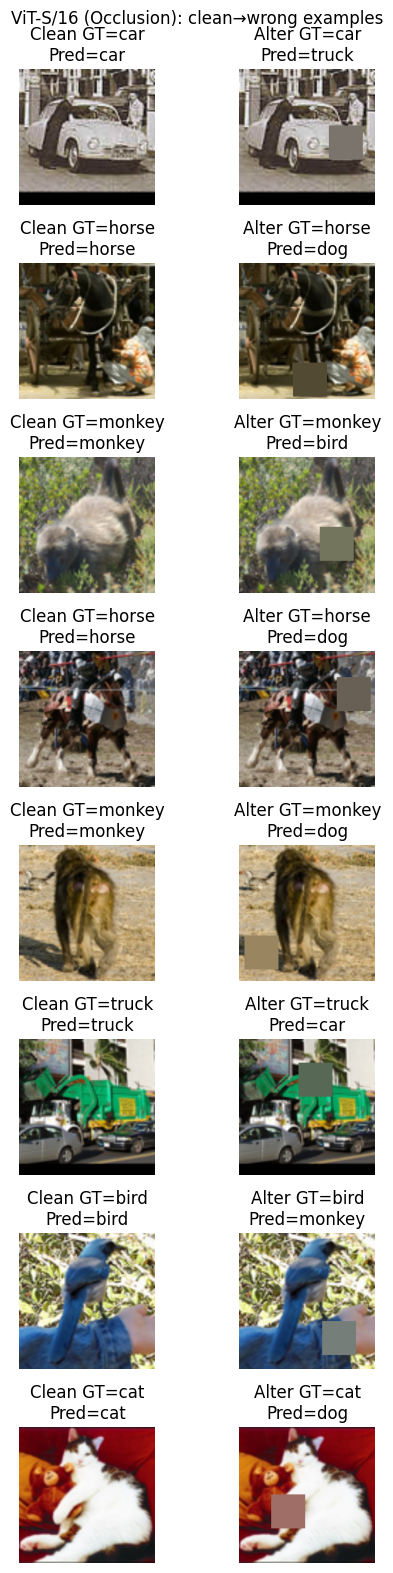

In [35]:
# 6F -> flip gallery , correct on clean adn wrong on altered
@torch.no_grad()
def collect_flips(model, clean_ds, altered_ds, max_show=8):
    model.eval()
    flips = []
    # assume same order/labels across test variants
    for i in range(len(clean_ds)):
        x_c, y  = clean_ds[i]
        x_a, y2 = altered_ds[i]
        assert y == y2
        pc = model(x_c.unsqueeze(0).to(DEVICE)).argmax(1).item()
        pa = model(x_a.unsqueeze(0).to(DEVICE)).argmax(1).item()
        if (pc == y) and (pa != y):
            flips.append((i, y, pc, pa))
        if len(flips) >= max_show:
            break
    return flips

def show_flips(model_name, flips, clean_ds, altered_ds):
    n = len(flips)
    if n == 0:
        print(f"{model_name}: no clean→wrong flips found in first scan.")
        return

    # get class names (CIFAR-10/STL-10 usually expose .classes)
    if hasattr(clean_ds, "dataset") and hasattr(clean_ds.dataset, "classes"):
        class_names = clean_ds.dataset.classes
    elif hasattr(clean_ds, "classes"):
        class_names = clean_ds.classes
    else:
        # fallback: just use indices as strings
        class_names = [str(i) for i in range(10)]

    fig, axs = plt.subplots(n, 2, figsize=(5, 2*n))
    fig.suptitle(f"{model_name}: clean→wrong examples")
    for row,(i,y,pc,pa) in enumerate(flips):
        img_c,_ = clean_ds[i]
        img_a,_ = altered_ds[i]

        def denorm(img):
            x = img.numpy().transpose(1,2,0)
            x = (x * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)).clip(0,1)
            return x

        gt_name   = class_names[y]
        pc_name   = class_names[pc]
        pa_name   = class_names[pa]

        axs[row,0].imshow(denorm(img_c)); axs[row,0].axis('off')
        axs[row,0].set_title(f"Clean GT={gt_name}\nPred={pc_name}")

        axs[row,1].imshow(denorm(img_a)); axs[row,1].axis('off')
        axs[row,1].set_title(f"Alter GT={gt_name}\nPred={pa_name}")

    plt.tight_layout(); plt.show()

# --- Run comparisons ---

# ResNet: Patch-shuffle (texture trap), and Occlusion
flips_r_shuf = collect_flips(resnet, test_ds, shuffle_test_ds, max_show=8)
show_flips("ResNet-50 (Shuffle)", flips_r_shuf, test_ds, shuffle_test_ds)

flips_r_occ = collect_flips(resnet, test_ds, occl_test_ds, max_show=8)
show_flips("ResNet-50 (Occlusion)", flips_r_occ, test_ds, occl_test_ds)

# ViT: Shift (positional sensitivity), and Occlusion
flips_v_shift = collect_flips(vit, test_ds, shift_test_ds, max_show=8)
show_flips("ViT-S/16 (Shift)", flips_v_shift, test_ds, shift_test_ds)

flips_v_occ = collect_flips(vit, test_ds, occl_test_ds, max_show=8)
show_flips("ViT-S/16 (Occlusion)", flips_v_occ, test_ds, occl_test_ds)

In [36]:
# 6G -> light weight loser level shape texture metric

@torch.no_grad()
def shape_texture_proxy(model):
    # Clean pred vs Shuffle pred agreement (layout destroyed)
    P_clean, Y = preds_and_labels(model, test_loader)
    P_shuf,  _ = preds_and_labels(model, shuffle_loader)
    # "shape-leaning proxy": how often it keeps the same *clean* class when layout is broken (should drop if it used layout strongly)
    keep_ratio = (P_clean == P_shuf).mean()

    #colour robustness: clean vs grayscale accuracy delta already computed,ut add normalized retention
    A_clean = evaluate(model, test_loader)
    A_gray  = evaluate(model, gray_loader)
    color_retention = A_gray / max(1e-6, A_clean)
    return keep_ratio, color_retention

r_keep, r_color = shape_texture_proxy(resnet)
v_keep, v_color = shape_texture_proxy(vit)

print(f"ResNet-50 — shuffle keep ratio: {r_keep:.3f} | color retention: {r_color:.3f}")
print(f"ViT-S/16  — shuffle keep ratio: {v_keep:.3f} | color retention: {v_color:.3f}")

ResNet-50 — shuffle keep ratio: 0.895 | color retention: 0.964
ViT-S/16  — shuffle keep ratio: 0.758 | color retention: 0.952


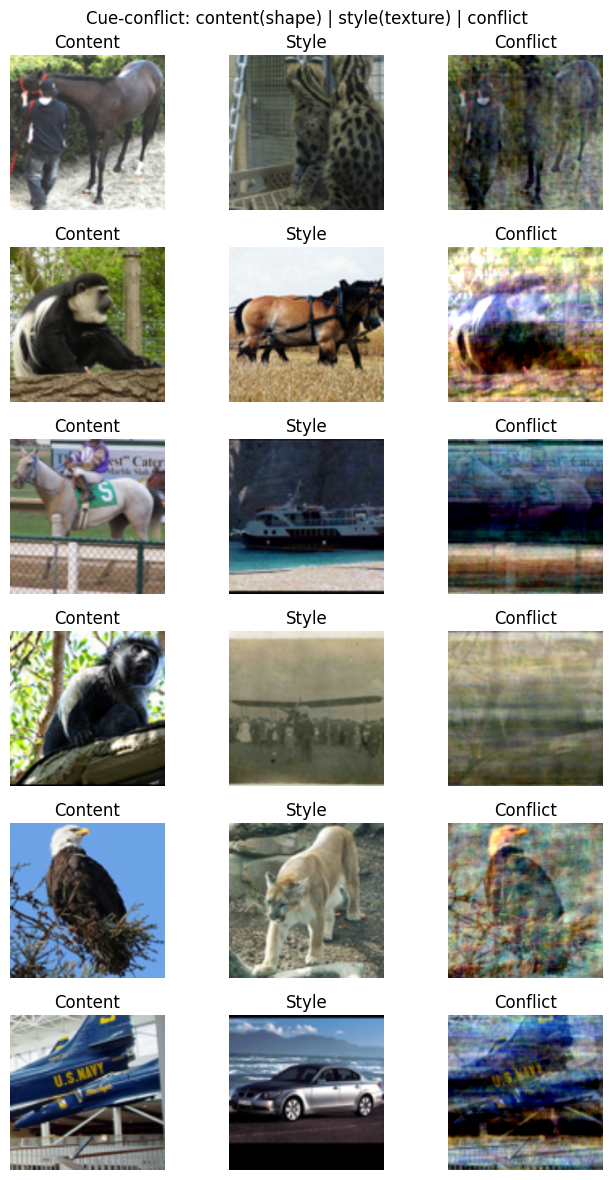

Shape bias (%) — ResNet-50: 74.3  (shape hits=26, texture hits=9)
Shape bias (%) — ViT-S/16 : 66.7  (shape hits=14, texture hits=7)


In [28]:
# 6 H -> cue conflict image svia fft ampliitude swap

from PIL import Image
import matplotlib.pyplot as plt

def to_uint8(img_tensor):
    x = img_tensor.clone().cpu().numpy().transpose(1,2,0)
    x = (x * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)).clip(0,1)
    return (x*255).astype(np.uint8)

def from_uint8(arr):
    x = arr.astype(np.float32)/255.0
    x = (x - np.array(IMAGENET_MEAN)) / np.array(IMAGENET_STD)
    return torch.tensor(x.transpose(2,0,1))

def fft_amplitude_phase(img):  # img: HxWxC uint8 (0..255)
    f = np.fft.fft2(img.astype(np.float32), axes=(0,1))
    amp, phase = np.abs(f), np.angle(f)
    return amp, phase

def fft_reconstruct(amp, phase):
    f = amp * np.exp(1j * phase)
    img = np.fft.ifft2(f, axes=(0,1)).real
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def amplitude_swap_conflict(content_uint8, style_uint8, alpha=1.0):
    # alpha=1.0 = full style amplitude; smaller alpha blends some content amplitude
    Ac, Pc = fft_amplitude_phase(content_uint8)
    As, Ps = fft_amplitude_phase(style_uint8)
    A_mix = (1-alpha)*Ac + alpha*As
    conflict = fft_reconstruct(A_mix, Pc)  # phase from content preserves shape
    return conflict

#build a small set of (content, style) pairs with different classd
# take N pairs by sampling random indices until labels differ
N = 60   # keep small to be fast
pairs = []
rng = np.random.default_rng(SEED)
idxs = rng.choice(len(test_ds), size=3*N, replace=False)  # sample pool from test set
k = 0
while len(pairs) < N and k < len(idxs)-1:
    i = int(idxs[k]); j = int(idxs[k+1]); k += 2
    (xc, yc) = test_ds[i]   # content
    (xs, ys) = test_ds[j]   # style
    if yc != ys:
        pairs.append((i, j, int(yc), int(ys)))

#generate conflict tensors aligned to model input
def make_conflict_batch(pairs, alpha=1.0):
    conflict_tensors = []
    shape_labels = []
    texture_labels = []
    viz_triplets = []  # (content_uint8, style_uint8, conflict_uint8) for a few examples
    for t, (i, j, yc, ys) in enumerate(pairs):
        xc, _ = test_ds[i]   # normalized tensor (3,224,224)
        xs, _ = test_ds[j]
        cu8 = to_uint8(xc)
        su8 = to_uint8(xs)
        confl = amplitude_swap_conflict(cu8, su8, alpha=alpha)
        confl_t = from_uint8(confl).float()
        conflict_tensors.append(confl_t)
        shape_labels.append(yc)
        texture_labels.append(ys)
        if t < 6:  # keep some for a panel
            viz_triplets.append((cu8, su8, confl))
    batch = torch.stack(conflict_tensors, dim=0)  # (N,3,224,224), normalized
    return batch, np.array(shape_labels), np.array(texture_labels), viz_triplets

conflict_x, shape_y, texture_y, viz_trip = make_conflict_batch(pairs, alpha=1.0)

#visualise a few triplets
fig, axs = plt.subplots(len(viz_trip), 3, figsize=(7, 2*len(viz_trip)))
fig.suptitle("Cue-conflict: content(shape) | style(texture) | conflict")
for r,(cu8,su8,cf8) in enumerate(viz_trip):
    axs[r,0].imshow(cu8); axs[r,0].set_title("Content"); axs[r,0].axis('off')
    axs[r,1].imshow(su8); axs[r,1].set_title("Style");   axs[r,1].axis('off')
    axs[r,2].imshow(cf8); axs[r,2].set_title("Conflict");axs[r,2].axis('off')
plt.tight_layout(); plt.show()

@torch.no_grad()
def shape_bias_percent(model, conflict_batch, shape_labels, texture_labels):
    model.eval()
    preds = []
    for i in range(0, len(conflict_batch), CFG.batch_size):
        x = conflict_batch[i:i+CFG.batch_size].to(DEVICE)
        p = model(x).argmax(1).cpu().numpy()
        preds.append(p)
    preds = np.concatenate(preds)
    # count how often pred == shape label vs pred == texture label
    shape_hits = (preds == shape_labels).sum()
    texture_hits = (preds == texture_labels).sum()
    denom = max(1, (shape_hits + texture_hits))
    shape_bias = 100.0 * shape_hits / denom
    return shape_bias, shape_hits, texture_hits, preds

#valuate shape-bias % for both models
r_shape_bias, r_sh, r_tx, r_preds = shape_bias_percent(resnet, conflict_x, shape_y, texture_y)
v_shape_bias, v_sh, v_tx, v_preds = shape_bias_percent(vit,    conflict_x, shape_y, texture_y)
print(f"Shape bias (%) — ResNet-50: {r_shape_bias:.1f}  (shape hits={r_sh}, texture hits={r_tx})")
print(f"Shape bias (%) — ViT-S/16 : {v_shape_bias:.1f}  (shape hits={v_sh}, texture hits={v_tx})")

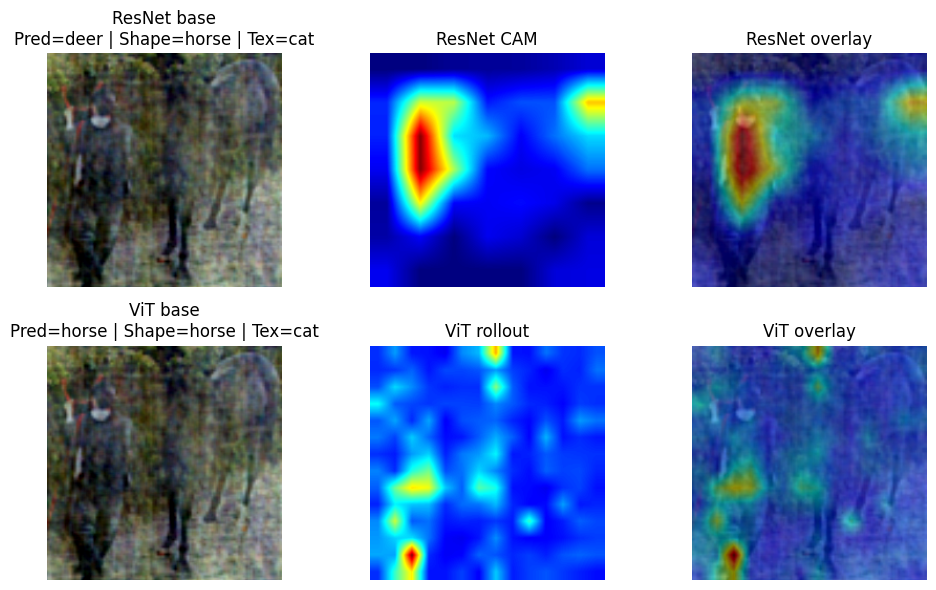

In [37]:
# 6 I -> visalize on conflict image - cam vs rollout
# pick an index from the conflict batch

# gen ai was used to take help i nmaking this cell block
idx_demo = 0
conf_img = conflict_x[idx_demo:idx_demo+1].to(DEVICE)
shape_lbl = int(shape_y[idx_demo])
text_lbl  = int(texture_y[idx_demo])

# --- get class names (CIFAR-10 / STL-10 expose .classes) ---
if hasattr(test_ds, "dataset") and hasattr(test_ds.dataset, "classes"):
    class_names = test_ds.dataset.classes
elif hasattr(test_ds, "classes"):
    class_names = test_ds.classes
else:
    class_names = [str(i) for i in range(10)]

shape_name = class_names[shape_lbl]
text_name  = class_names[text_lbl]

# --- ResNet Grad-CAM ---
cam_r = GradCAM_ResNet50(resnet)
base_r, heat_r, overlay_r, _ = cam_r(conf_img)

# --- ViT rollout (torchvision version) ---
base_v, heat_v, overlay_v = vit_attention_rollout_torchvision(vit, conf_img)

# --- Predictions ---
r_pred = resnet(conf_img).argmax(1).item()
v_pred = vit(conf_img).argmax(1).item()
r_pred_name = class_names[r_pred]
v_pred_name = class_names[v_pred]

# --- Visualization ---
fig, axs = plt.subplots(2, 3, figsize=(10,6))

axs[0,0].imshow(base_r)
axs[0,0].set_title(f"ResNet base\nPred={r_pred_name} | Shape={shape_name} | Tex={text_name}")
axs[0,1].imshow(heat_r);
axs[0,1].set_title("ResNet CAM")
axs[0,2].imshow(overlay_r);
axs[0,2].set_title("ResNet overlay")

axs[1,0].imshow(base_v)
axs[1,0].set_title(f"ViT base\nPred={v_pred_name} | Shape={shape_name} | Tex={text_name}")
axs[1,1].imshow(heat_v);
axs[1,1].set_title("ViT rollout")
axs[1,2].imshow(overlay_v);
axs[1,2].set_title("ViT overlay")

for ax in axs.ravel():
    ax.axis('off')

plt.tight_layout()
plt.show()



In [38]:
!wget https://www.eecs.qmul.ac.uk/~dl307/project_iccv2017/PACS.zip
!unzip PACS.zip -d /content/

--2025-09-21 14:42:52--  https://www.eecs.qmul.ac.uk/~dl307/project_iccv2017/PACS.zip
Resolving www.eecs.qmul.ac.uk (www.eecs.qmul.ac.uk)... 138.37.95.150
Connecting to www.eecs.qmul.ac.uk (www.eecs.qmul.ac.uk)|138.37.95.150|:443... connected.
ERROR: cannot verify www.eecs.qmul.ac.uk's certificate, issued by ‘CN=Sectigo Public Server Authentication CA OV R36,O=Sectigo Limited,C=GB’:
  Unable to locally verify the issuer's authority.
To connect to www.eecs.qmul.ac.uk insecurely, use `--no-check-certificate'.
unzip:  cannot find or open PACS.zip, PACS.zip.zip or PACS.zip.ZIP.


In [39]:
import os
from torchvision.datasets import ImageFolder

# from google.colab import drive
# drive.mount('/content/drive')

# PACS_ROOT = "/content/drive/MyDrive/PACS"

# #PACS_ROOT = "/content/PACS"  # change
# PACS_FOUND = os.path.isdir(PACS_ROOT) and all(os.path.isdir(os.path.join(PACS_ROOT,d)) for d in ["photo","art_painting","cartoon","sketch"])

# if PACS_FOUND:
#     pacs_tf = test_tf  # same 224 norm
#     pacs_sketch = ImageFolder(os.path.join(PACS_ROOT, "sketch"), transform=pacs_tf)
#     pacs_sketch_loader = DataLoader(pacs_sketch, batch_size=CFG.batch_size, shuffle=False,
#                                     num_workers=CFG.num_workers, pin_memory=True)
#     r_pacs = evaluate(resnet, pacs_sketch_loader)
#     v_pacs = evaluate(vit,    pacs_sketch_loader)
#     print(f"PACS Sketch (zero-shot domain shift) — ResNet50: {r_pacs:.3f} | ViT-S/16: {v_pacs:.3f}")

#     # show a few PACS sketch samples with preds
#     import matplotlib.pyplot as plt
#     @torch.no_grad()
#     def show_pacs_preds(model, ds, n=8, title=""):
#         idxs = np.random.choice(len(ds), size=n, replace=False)
#         fig, axs = plt.subplots(1,n, figsize=(n*2.2,2.2))
#         fig.suptitle(title)
#         for ax,i in zip(axs, idxs):
#             x,y = ds[i]
#             p = model(x.unsqueeze(0).to(DEVICE)).argmax(1).item()
#             img = (x.numpy().transpose(1,2,0)*np.array(IMAGENET_STD)+np.array(IMAGENET_MEAN)).clip(0,1)
#             ax.imshow(img); ax.axis('off'); ax.set_title(f"GT={y} P={p}")
#         plt.show()

#     show_pacs_preds(resnet, pacs_sketch, title="ResNet on PACS Sketch")
#     show_pacs_preds(vit,    pacs_sketch, title="ViT on PACS Sketch")
# else:
#     print("PACS root not found — skipping domain generalization cell. Mount your PACS folder to enable .... pacs dataset check?")

if not os.path.isdir("/content/PACS"):
    print("PACS folder not found in /content/, attempting download...")
    !wget --no-check-certificate https://www.eecs.qmul.ac.uk/~dl307/project_iccv2017/PACS.zip -O /content/PACS.zip
    if os.path.exists("/content/PACS.zip"):
        !unzip -q /content/PACS.zip -d /content/
        print("PACS downloaded and unzipped.")
    else:
        print("Warning: download failed; will try to use mounted Drive.")

# 2. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 3. Check for PACS in Drive or local
possible_paths = [
    "/content/PACS",
    "/content/drive/MyDrive/PACS",
    "/content/drive/MyDrive/Datasets/PACS",
    "/content/drive/MyDrive/pacs",
]

PACS_ROOT = None
for p in possible_paths:
    if os.path.isdir(p):
        # check it has the 4 domain subfolders
        subs = ["photo", "art_painting", "cartoon", "sketch"]
        if all(os.path.isdir(os.path.join(p, d)) for d in subs):
            PACS_ROOT = p
            print(f"PACS dataset found at {PACS_ROOT}")
            break

if PACS_ROOT is None:
    print("PACS dataset not found in any expected location; skipping PACS evaluation.")
else:
    # set up loader
    pacs_tf = test_tf  # your existing test transform
    pacs_sketch = ImageFolder(os.path.join(PACS_ROOT, "sketch"), transform=pacs_tf)
    pacs_sketch_loader = DataLoader(pacs_sketch, batch_size=CFG.batch_size, shuffle=False,
                                    num_workers=CFG.num_workers, pin_memory=True)

    # Evaluate
    r_pacs = evaluate(resnet, pacs_sketch_loader)
    v_pacs = evaluate(vit, pacs_sketch_loader)
    print(f"PACS Sketch (zero-shot domain shift) — ResNet50: {r_pacs:.3f} | ViT-S/16: {v_pacs:.3f}")

    # Some sample predictions
    @torch.no_grad()
    def show_pacs_preds(model, ds, n=8, title=""):
        idxs = np.random.choice(len(ds), size=n, replace=False)
        fig, axs = plt.subplots(1,n, figsize=(n*2.2,2.2))
        fig.suptitle(title)
        for ax,i in zip(axs, idxs):
            x,y = ds[i]
            p = model(x.unsqueeze(0).to(DEVICE)).argmax(1).item()
            # get class names
            if hasattr(ds, "classes"):
                cname = ds.classes
            elif hasattr(ds, "dataset") and hasattr(ds.dataset, "classes"):
                cname = ds.dataset.classes
            else:
                cname = [str(i) for i in range(CFG.num_classes)]
            gt_name = cname[y]
            p_name  = cname[p]
            img = (x.numpy().transpose(1,2,0)*np.array(IMAGENET_STD)+np.array(IMAGENET_MEAN)).clip(0,1)
            ax.imshow(img); ax.axis('off'); ax.set_title(f"GT={gt_name} P={p_name}")
        plt.tight_layout(); plt.show()

    show_pacs_preds(resnet, pacs_sketch, title="ResNet on PACS Sketch")
    show_pacs_preds(vit,    pacs_sketch, title="ViT on PACS Sketch")

PACS folder not found in /content/, attempting download...
--2025-09-21 14:43:54--  https://www.eecs.qmul.ac.uk/~dl307/project_iccv2017/PACS.zip
Resolving www.eecs.qmul.ac.uk (www.eecs.qmul.ac.uk)... 138.37.95.150
Connecting to www.eecs.qmul.ac.uk (www.eecs.qmul.ac.uk)|138.37.95.150|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 404 Not Found
2025-09-21 14:43:55 ERROR 404: Not Found.

[/content/PACS.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/PACS.zip or
        /content/PACS.zip.zip, and cannot find /content/PACS.zip.ZIP, period.
PACS downloaded and unzipped.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/conte

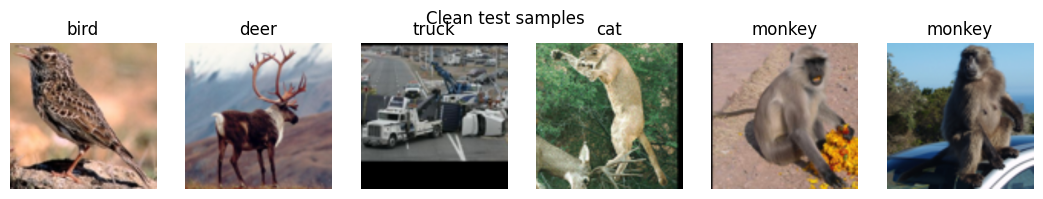

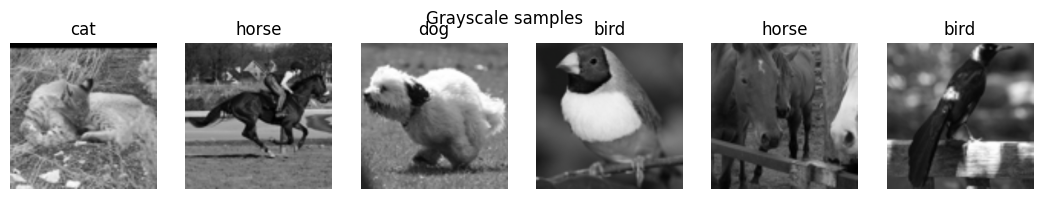

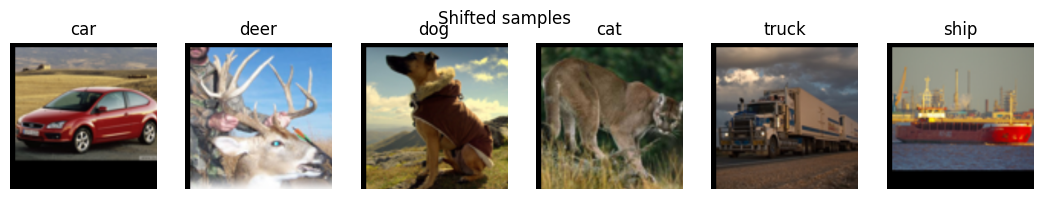

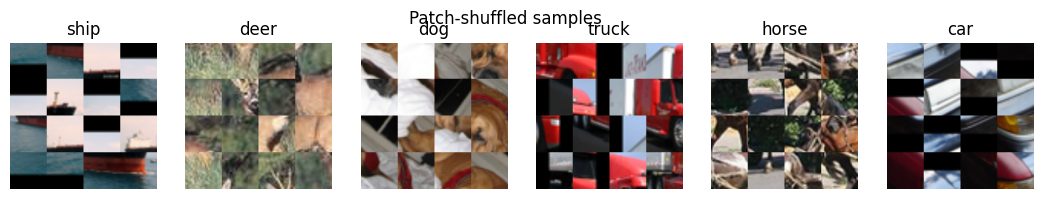

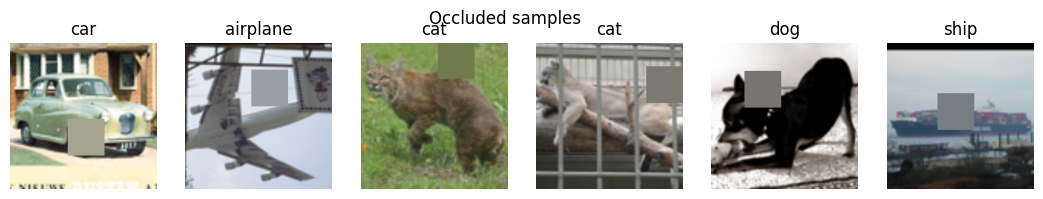

In [ ]:
import matplotlib.pyplot as plt
# generative ai was used to produce the plotting part of this code. because that is repetitive.
import matplotlib.pyplot as plt

# helper: get class names from dataset
if hasattr(test_ds, "dataset") and hasattr(test_ds.dataset, "classes"):
    class_names = test_ds.dataset.classes
elif hasattr(test_ds, "classes"):
    class_names = test_ds.classes
else:
    class_names = [str(i) for i in range(10)]  # fallback

#visualization
def show_batch(dset, n=6, title=""):
    # plot a few images un-normalized from a dataset
    idxs = np.random.choice(len(dset), size=n, replace=False)
    fig, axs = plt.subplots(1, n, figsize=(n*2.2, 2.2))
    fig.suptitle(title)
    for ax, i in zip(axs, idxs):
        img, label = dset[i]
        # de-normalize to show
        img_np = img.numpy().transpose(1,2,0)
        img_np = (img_np * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)).clip(0,1)
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(class_names[label])  # <-- use name instead of int
    plt.show()

# --- show a few from each altered test ---
show_batch(test_ds, n=6, title="Clean test samples")
show_batch(gray_test_ds, n=6, title="Grayscale samples")
show_batch(shift_test_ds, n=6, title="Shifted samples")
show_batch(shuffle_test_ds, n=6, title="Patch-shuffled samples")
show_batch(occl_test_ds, n=6, title="Occluded samples")

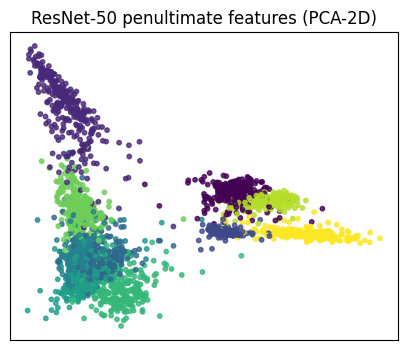

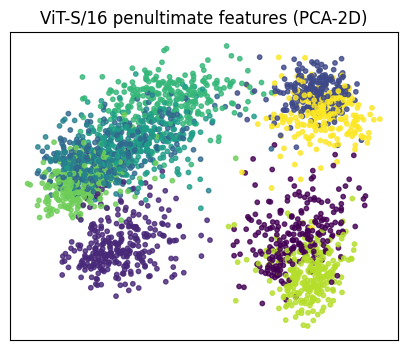

In [42]:
# feature space prob -> penultimate mbeddings + princple comp. analysis to 2d
# compare clustering for resnet vs vit on small subset
#colour points by class id 0-9

from sklearn.decomposition import PCA

@torch.no_grad()
def extract_features(model, loader, max_batches=20):
    model.eval()
    feats = []
    labels = []
    hook_out = {}

    if isinstance(model, models.ResNet):
        # --- ResNet: penultimate = avgpool ---
        def hook_fn(module, input, output):
            hook_out['feat'] = output

        handle = model.avgpool.register_forward_hook(hook_fn)

        for i, (imgs, ys) in enumerate(loader):
            if i >= max_batches: break
            imgs = imgs.to(DEVICE)
            _ = model(imgs)
            f = hook_out['feat'].squeeze()  # (N, 2048)
            if f.ndim > 2:  # safety: squeeze down (N, C)
                f = f.mean(dim=(2,3))
            feats.append(f.detach().cpu())
            labels.append(ys)

        handle.remove()

    else:
        # --- ViT ---
        for i, (imgs, ys) in enumerate(loader):
            if i >= max_batches: break
            imgs = imgs.to(DEVICE)
            f = model.forward_features(imgs)  # (N, num_tokens, D) or dict
            if isinstance(f, dict):
                f = f["last_hidden_state"]  # HuggingFace style
            # keep only CLS token (index 0)
            f = f[:,0,:]   # (N, D)
            feats.append(f.detach().cpu())
            labels.append(ys)

    feats = torch.cat(feats).numpy()
    labels = torch.cat(labels).numpy()
    return feats, labels

#small subset for quick
sub_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

resnet_feats, resnet_lbls = extract_features(resnet, sub_loader, max_batches=20)
vit_feats,vit_lbls= extract_features(vit,sub_loader, max_batches=20)

pca2 = PCA(n_components=2, random_state=SEED)
r2 = pca2.fit_transform(resnet_feats)
v2 = pca2.fit_transform(vit_feats)

# scatter plots
def scatter_2d(X2, y, title):
    plt.figure(figsize=(5,4))
    plt.scatter(X2[:,0], X2[:,1], c=y, s=10, alpha=0.8)
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.show()

scatter_2d(r2, resnet_lbls, "ResNet-50 penultimate features (PCA-2D)")
scatter_2d(v2, vit_lbls,    "ViT-S/16 penultimate features (PCA-2D)")



In [43]:
def pct(x): return f"{100.0*x:5.1f}%"

print("\n=== STL10 — Summary (ResNet50 vs ViT-S/16) ===")
print(f"Clean               | R50: {pct(resnet_clean)}   | ViT: {pct(vit_clean)}")
print(f"Grayscale           | R50: {pct(resnet_gray)}   | ViT: {pct(vit_gray)}")
print(f"Δ drop (no color)   | R50: {pct(resnet_clean-resnet_gray)} | ViT: {pct(vit_clean-vit_gray)}")
print(f"Shifted accuracy    | R50: {pct(resnet_shift_acc)} | ViT: {pct(vit_shift_acc)}")
print(f"Shift consistency   | R50: {pct(resnet_shift_cons)} | ViT: {pct(vit_shift_cons)}")
print(f"Patch-shuffle       | R50: {pct(resnet_shuffle)} | ViT: {pct(vit_shuffle)}")
print(f"Occlusion           | R50: {pct(resnet_occl)}   | ViT: {pct(vit_occl)}")
print("-----------------------------------------------------")



=== STL10 — Summary (ResNet50 vs ViT-S/16) ===
Clean               | R50:  96.5%   | ViT:  96.0%
Grayscale           | R50:  93.0%   | ViT:  91.5%
Δ drop (no color)   | R50:   3.5% | ViT:   4.6%
Shifted accuracy    | R50:  96.5% | ViT:  95.5%
Shift consistency   | R50:  98.2% | ViT:  96.4%
Patch-shuffle       | R50:  88.0% | ViT:  74.5%
Occlusion           | R50:  96.2%   | ViT:  95.1%
-----------------------------------------------------
